In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_215219/254083166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-27 15:25:21.840435: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 15:25:21.885862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 15:25

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [31]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
#data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=pd.concat([data_water, data_ice, data_mixed])
#data_all=pd.concat([data_ice])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

df=data_all.copy()
#data_all=hf.add_MSI_noise(data_all,channel_labels)

In [32]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels_one=['Clear_B12']
y_labels_all=['Clear_B02','Clear_B03','Clear_B04','Clear_B05',
              'Clear_B06','Clear_B07','Clear_B08', 'Clear_B09',
              'Clear_B10','Clear_B11','Clear_B12','Clear_B13']

X_truth=df_truth[X_labels]


#df=hf.normalise_input_df(data_all,X_labels)
#df=hf.add_noise(df,X_labels,sigma=0.001)


X=df[X_labels]
y_all=df[y_labels_all]
y_one=df[y_labels_one]

X_train, X_test, y_train_all, y_test_all=train_test_split(X,y_all,test_size=0.05)

indexes_training_data=y_train_all.index
indexes_test_data=y_test_all.index

y_train_one=y_one.iloc[indexes_training_data]
y_test_one=y_one.iloc[indexes_test_data]



In [5]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]


Best model out of total max epochs found at epoch 260


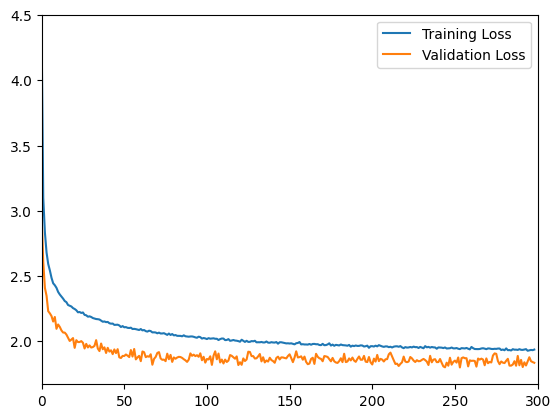

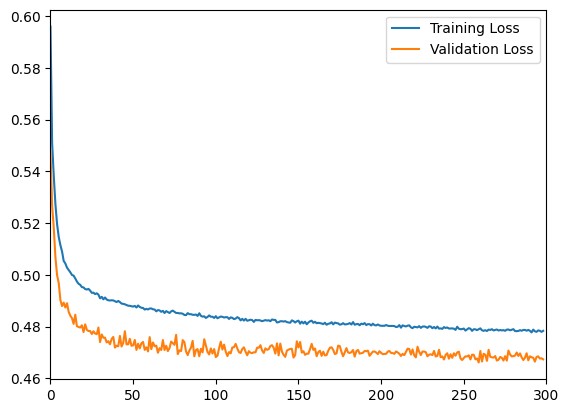

In [6]:
quantiles=np.array([0.1,0.5,0.9])
batch_size=500
save=False

nepochs=300
model_all=QuantileNetwork(quantiles=quantiles)
model_one=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
n_nodes_all=128
sequence_all=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes_all),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_all,n_nodes_all),
    nn.ReLU(),
    nn.Linear(n_nodes_all, len(quantiles)*len(y_labels_all)) #Output dimesion is number of quantiles times number of target variables
)
n_nodes_one=64
sequence_one=lambda: nn.Sequential(
    nn.Linear(len(X_labels),n_nodes_one),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(n_nodes_one,n_nodes_one),
    nn.ReLU(),
    nn.Linear(n_nodes_one, len(quantiles)*len(y_labels_one)) #Output dimesion is number of quantiles times number of target variables
)

model_all.fit(X_train.to_numpy(),y_train_all.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence_all(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_estimate_1_v_all_channels/all',model=model_all,X_test=X_test,y_test=y_test_all)
    print("Model all saved...")

model_one.fit(X_train.to_numpy(),y_train_one.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence_one(),
          lr=0.003,
          data_norm=True,
          verbose=False,
          plot_training=True)

if save:
    hf.save_model_and_test_data(filepath='pytorch_models/test_estimate_1_v_all_channels/one',model=model_one,X_test=X_test,y_test=y_test_one)
    print("Model one saved...")


## Load trained models and Visualise

In [13]:
#Load models
model_all,X_test,y_test_all=hf.load_model_and_test_data('pytorch_models/test_estimate_1_v_all_channels/all')
model_one,X_test,y_test_one=hf.load_model_and_test_data('pytorch_models/test_estimate_1_v_all_channels/one')


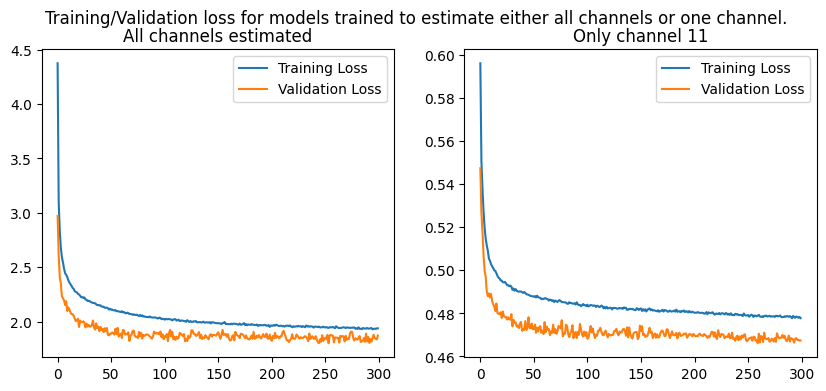

In [17]:
plt.rcParams["figure.figsize"] = [10, 4]
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("Training/Validation loss for models trained to estimate either all channels or one channel.")

ax[0].plot(model_all.train_loss.data.cpu().numpy())
ax[0].plot(model_all.val_loss.data.cpu().numpy())
ax[0].set_title("All channels estimated")
ax[0].legend(['Training Loss','Validation Loss'])

ax[1].plot(model_one.train_loss.data.cpu().numpy())
ax[1].plot(model_one.val_loss.data.cpu().numpy())
ax[1].set_title("Only channel 11")
ax[1].legend(['Training Loss','Validation Loss'])

In [33]:
cot_limit=True
cot_limit_val=100
if cot_limit:
    df_test=df.iloc[X_test.index]
    X_test=df_test[df_test['COT']<cot_limit_val][X_labels]
    indexes=X_test.index
    y_test_all=df.iloc[indexes][y_labels_all]
    y_test_one=df.iloc[indexes][y_labels_one]

In [34]:
#Make predictions
y_preds_all=model_all.predict(X_test.to_numpy())
y_preds_all_11=y_preds_all[:,10,:]
y_preds_one=model_one.predict(X_test.to_numpy())
y_preds_one=y_preds_one[:,0,:]



In [35]:
y_test_all

,Clear_B02,Clear_B03,Clear_B04,Clear_B05,Clear_B06,Clear_B07,Clear_B08,Clear_B09,Clear_B10,Clear_B11,Clear_B12,Clear_B13
21671,0.21087,0.17692,0.22072,0.17860,0.37981,0.92810,0.78089,0.97762,0.02286,0.00042,0.89440,0.69462
9620,0.95381,0.88865,0.93374,0.89009,0.93108,0.96802,0.88632,0.99259,0.15205,0.00035,0.93389,0.11599
29488,0.22888,0.24334,0.36015,0.21977,0.47492,0.95741,0.83933,0.99119,0.06350,0.00027,0.83922,0.54506
13763,0.19375,0.21648,0.43038,0.17925,0.52025,0.95550,0.82767,0.99135,0.04760,0.00036,0.66543,0.49143
5953,0.24266,0.23546,0.41644,0.23832,0.57758,0.97309,0.95554,0.98778,0.55732,0.00690,0.86865,0.76320
...,...,...,...,...,...,...,...,...,...,...,...,...
40002,0.58255,0.61564,0.81153,0.81796,0.98356,0.99315,0.95936,1.00090,0.46408,0.00147,0.95456,0.92666
42330,0.23319,0.23810,0.39804,0.21457,0.58119,0.96291,0.85682,0.99284,0.08508,0.00036,0.93191,0.63667
28863,0.26587,0.21084,0.26564,0.18557,0.33608,0.88996,0.72775,0.95608,0.01380,0.00071,0.78672,0.46707
5989,0.33211,0.29294,0.32902,0.32239,0.36587,0.41439,0.36197,0.46881,0.01440,0.00064,0.55825,0.45893


In [36]:
## Calculate residuals
y_all=y_test_all.to_numpy()[:,10]
res_all=y_all-y_preds_all_11[:,1]

y_one=y_test_one.to_numpy()[:,0]
res_one=y_one-y_preds_one[:,1]

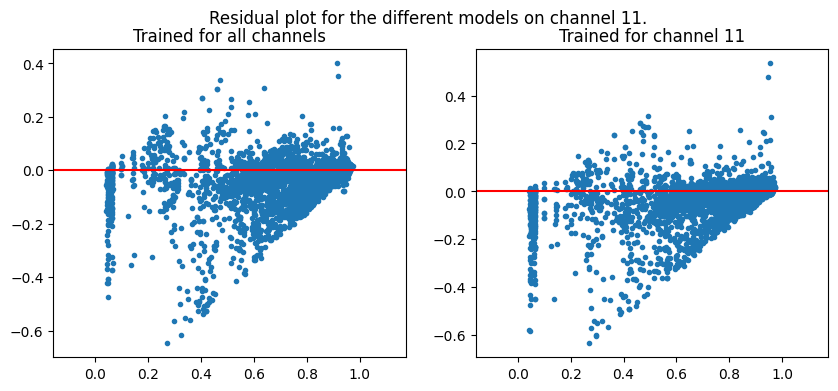

In [37]:
#Plot residuals
fig, ax =plt.subplots(nrows=1,ncols=2)
fig.suptitle("Residual plot for the different models on channel 11.")

ax[0].plot(y_all,res_all,'.')
ax[0].set_title("Trained for all channels")
ax[0].hlines(0,xmin=-1,xmax=10,colors='r')
ax[0].set_xlim((np.min(y_all)-0.2,np.max(y_all)+0.2))

ax[1].plot(y_one,res_one,'.')
ax[1].set_title("Trained for channel 11")
ax[1].hlines(0,xmin=-1,xmax=10,colors='r')
ax[1].set_xlim((np.min(y_one)-0.2,np.max(y_one)+0.2))

plt.show()


In [38]:
r2_all=r2_score(y_all,y_preds_all_11[:,1])
r2_one=r2_score(y_one,y_preds_one[:,1])
mse_all=mean_squared_error(y_all,y_preds_all_11[:,1])
mse_one=mean_squared_error(y_one,y_preds_one[:,1])

print("R2 score channel 11, model trained for all channels: "+str(r2_all))
print("R2 score channel 11, model trained for channel 11: "+str(r2_one))
print(" ")
print("MSE score channel 11, model trained for all channels: "+str(mse_all))
print("MSE score channel 11, model trained for channel 11: "+str(mse_one))


R2 score channel 11, model trained for all channels: 0.8617288758533437
R2 score channel 11, model trained for channel 11: 0.8679518406607767
 
MSE score channel 11, model trained for all channels: 0.00525021742044979
MSE score channel 11, model trained for channel 11: 0.005013928618717205


/tmp/ipykernel_215219/3709476801.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[0].errorbar(x=y_all_samps_sort
/tmp/ipykernel_215219/3709476801.py:36: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[1].errorbar(x=y_one_samps_sort


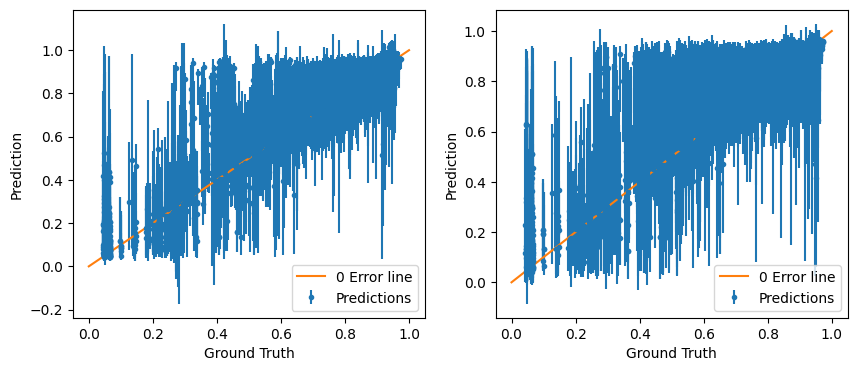

In [39]:
samples=len(X_test)

#Get ground truth y, all model
y_all_samps=y_all[0:samples]
sort_ind=np.argsort(y_all_samps)
y_all_samps_sort=y_all_samps[sort_ind]

#Get y predictions, all model
y_pred_all_samps=y_preds_all_11[0:samples,:]
y_pred_all_samps_sort=y_pred_all_samps[sort_ind,:]

#Get ground truth y, one model
y_one_samps=y_one[0:samples]
sort_ind_one=np.argsort(y_one_samps)
y_one_samps_sort=y_one_samps[sort_ind_one]

#Get y predictions, one model
y_pred_one_samps=y_preds_one[0:samples,:]
y_pred_one_samps_sort=y_pred_one_samps[sort_ind,:]


#plt.plot(y_plot_sort,'.')
fig,ax=plt.subplots(nrows=1,ncols=2)
ax[0].errorbar(x=y_all_samps_sort
             ,y=y_pred_all_samps_sort[:,1],
             yerr=[np.abs(y_pred_all_samps_sort[:,1]-y_pred_all_samps_sort[:,0]),
                   np.abs(y_pred_all_samps_sort[:,1]-y_pred_all_samps_sort[:,2])],
                    marker='.',fmt='.')
#plt.plot(cloudy_sort,'.')
line=np.linspace(0,1,100)
ax[0].plot(line,line)
ax[0].legend(['0 Error line','Predictions'])
ax[0].set_xlabel("Ground Truth")
ax[0].set_ylabel("Prediction")

ax[1].errorbar(x=y_one_samps_sort
             ,y=y_pred_one_samps_sort[:,1],
             yerr=[np.abs(y_pred_one_samps_sort[:,1]-y_pred_one_samps_sort[:,0]),
                   np.abs(y_pred_one_samps_sort[:,1]-y_pred_one_samps_sort[:,2])],
                    marker='.',fmt='.')
ax[1].plot(line,line)
ax[1].legend(['0 Error line','Predictions'])
ax[1].set_xlabel("Ground Truth")
ax[1].set_ylabel("Prediction")

plt.show()

/tmp/ipykernel_215219/4247111117.py:4: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[0].errorbar(x=np.linspace(0,samples,samples)
/tmp/ipykernel_215219/4247111117.py:17: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  ax[1].errorbar(x=np.linspace(0,samples,samples)


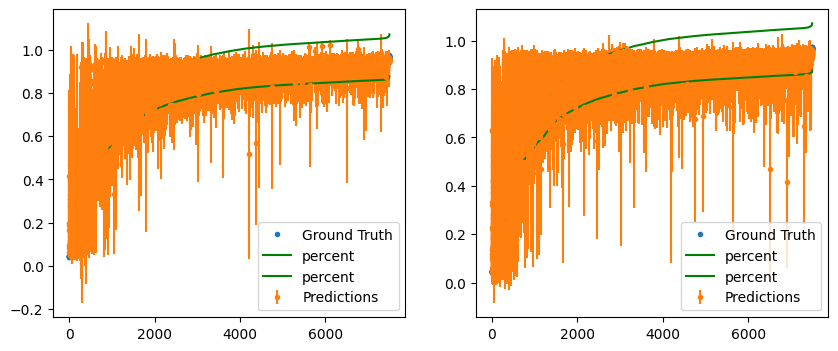

In [40]:
fig,ax =plt.subplots(nrows=1,ncols=2)

ax[0].plot(y_all_samps_sort,'.',label='Ground Truth')
ax[0].errorbar(x=np.linspace(0,samples,samples)
             ,y=y_pred_all_samps_sort[:,1],
             yerr=[np.abs(y_pred_all_samps_sort[:,1]-y_pred_all_samps_sort[:,0]),
                   np.abs(y_pred_all_samps_sort[:,1]-y_pred_all_samps_sort[:,2])],
                    marker='.',fmt='.',label='Predictions')

percent=0.1
ax[0].plot(y_all_samps_sort-y_all_samps_sort*percent,'g',label='percent')
ax[0].plot(y_all_samps_sort+y_all_samps_sort*percent,'g',label='percent')
#ax[0].legend(['Ground truth',str(percent*100)+' percent from ground','.','Predictions'])
ax[0].legend()

ax[1].plot(y_one_samps_sort,'.',label='Ground Truth')
ax[1].errorbar(x=np.linspace(0,samples,samples)
             ,y=y_pred_one_samps_sort[:,1],
             yerr=[np.abs(y_pred_one_samps_sort[:,1]-y_pred_one_samps_sort[:,0]),
                   np.abs(y_pred_one_samps_sort[:,1]-y_pred_one_samps_sort[:,2])],
                    marker='.',fmt='.',label='Predictions')

ax[1].plot(y_one_samps_sort-y_all_samps_sort*percent,'g',label='percent')
ax[1].plot(y_one_samps_sort+y_all_samps_sort*percent,'g',label='percent')
ax[1].legend()
#plt.plot(cloudy_sort,'.')
#plt.legend(['Ground truth','Cloudy signal','prediction'])
plt.show()

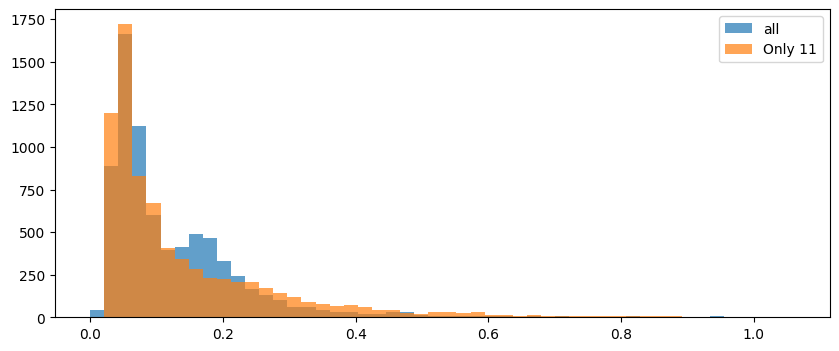

In [41]:
uncertainty_all=y_pred_all_samps_sort[:,2]-y_pred_all_samps_sort[:,0]
uncertainty_one=y_pred_one_samps_sort[:,2]-y_pred_one_samps_sort[:,0]

plt.hist(uncertainty_all,bins=50,range=[0,np.max(np.array([np.max(uncertainty_all),np.max(uncertainty_one)]))],alpha=0.7)
plt.hist(uncertainty_one,bins=50,range=[0,np.max(np.array([np.max(uncertainty_all),np.max(uncertainty_one)]))],alpha=0.7)
plt.legend(['all','Only 11'])

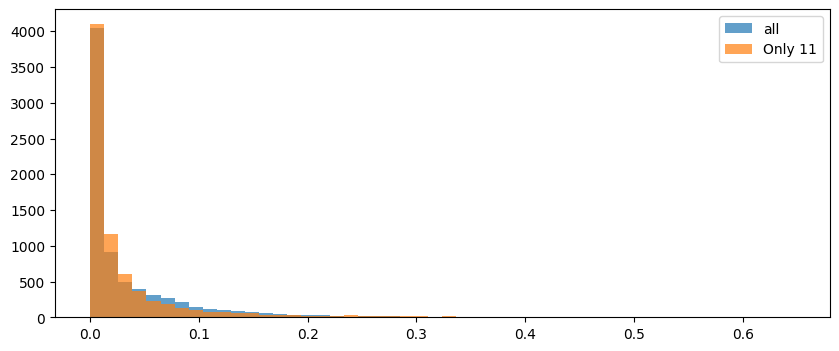

In [42]:
plt.hist(np.abs(res_all),bins=50,
         range=[0,np.max(np.array([np.max(np.abs(res_all)),np.max(np.abs(res_one))]))],
         alpha=0.7)
plt.hist(np.abs(res_one),bins=50,
         range=[0,np.max(np.array([np.max(np.abs(res_all)),np.max(np.abs(res_one))]))],
         alpha=0.7)
plt.legend(['all','Only 11'])

In [43]:
quant_rate_all=QuantileNetwork.quant_rate(y_test_all.to_numpy()[:,10],y_preds_all_11)
quant_rate_one=QuantileNetwork.quant_rate(y_test_one.to_numpy()[:,0],y_preds_one)

print("Quantile rate, model trained for all channels: "+str(quant_rate_all))
print("Quantile rate, model trained for channel 11: "+str(quant_rate_one))

Quantile rate, model trained for all channels: [0.10133333 0.6696     0.97946667]
Quantile rate, model trained for channel 11: [0.0672     0.59693333 0.9568    ]
